This note book is for applyying the feature extraction capabilites from an autoencoder to the tree classification method used on the plastics data in HW5 and HW6. 

In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#####imporating for the auto_encoder
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [0]:
import glob
import pandas as pd

%pylab inline
import h5py
from PIL import Image
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


# Going to directory with plastics challenge data( or to place it there). The files are pulled directecty from my git repo. 

In [0]:
#cd /content/gdrive/My\ Drive 
cd gdrive

/content/gdrive


In [0]:
 cd My\ Drive 

/content/gdrive/My Drive


In [0]:
mkdir hw9_data

In [0]:
cd hw9_data/

/content/gdrive/My Drive/hw9_data


In [0]:
! git clone "https://github.com/shaqsead16/plasticc_data_hw5"

Cloning into 'plasticc_data_hw5'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
ls 

plasticc_data_hw5/


In [0]:
cd plasticc_data_hw5/

/content/gdrive/My Drive/hw9_data/plasticc_data_hw5


In [0]:
ls

hw5_allfeatures.csv  hw_5_dat.zip                 README.md
hw_5_dat/            hw9_sparce_light_curves.npy


In [0]:
!unzip hw_5_dat.zip

Archive:  hw_5_dat.zip
   creating: hw_5_dat/
  inflating: hw_5_dat/plasticc_train_lightcurves.csv  
  inflating: hw_5_dat/plasticc_train_metadata.csv  


In [0]:
####loading the training set of light curves 
lcvs = pd.read_csv("hw_5_dat/plasticc_train_lightcurves.csv")

#lcvs = lcvs[:100000]
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [0]:
lcvs.tail(10) 

,object_id,mjd,passband,flux,flux_err,detected_bool
1421695,130779836,60542.0489,4,-60.500492,14.743795,0
1421696,130779836,60543.0247,4,-48.527161,24.004080,0
1421697,130779836,60545.9844,5,32.006413,77.931732,0
1421698,130779836,60546.9804,5,68.152985,56.351048,0
1421699,130779836,60548.9789,4,-60.066154,34.353317,0
1421700,130779836,60555.9838,4,-39.881969,46.477093,0
1421701,130779836,60560.0459,1,14.894439,18.947685,0
1421702,130779836,60571.0225,5,30.593130,50.695290,0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0
1421704,130779836,60588.0372,0,-41.214264,51.665123,0


In [0]:
#####getting the list of the filter types and lables
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [0]:
name_objs = np.unique(lcvs['object_id'])
num_of_objs = np.size(name_objs )

print(num_of_objs)

7848


In [0]:
###order of the objects counts upwards 

print(name_objs)

[      615       713       730 ... 130762946 130772921 130779836]


### My choice in structing the time series. 

I chose to use a sparse time series. At the time it would be a challenge in and of itself to estblish a universal interpolator (or conditional one) for all the time series, given they are of various sturcture (eg. SN vs varaible stars). 

I shift the time axes of all the light curves, such that the clock starts (t=0) 

*   I shift the time axes of all the light curves, such that the clock starts (t=0), and round to the nearst 0.5 day.
*   I create a uniform time vector for all the time series that has steps of 1/2 a day. The advantage of this is that I would only need to input the vector containing the flux, given all time series would woudl be aligned relative to their intial value. The flux vectors is filled with 0's for all times stamps with no corresponding observation(may cause problems)
*   I place all six filters on the same vector, this avoids having to implement and AE  for each type of filter (that would make the parameter space to large, 6 times the size of the central compression layer. Also,with the hopes of not losing any major distinction between light curves of different bands (to an AE they would all be just time series, with inherent distinction do to a feature it wouldn't know such as color.) 

*   For the instance that sequentia observations round to the same day, I push the duplcates forward 0.5 days. This will minorly shift the structure of light curve, but shouldn't have a major affect. 










In [0]:
###shifting the mjd to start at 0 for the first observation in each filter
def t_shifter(df):
    df_new_t = (df - df.min()) 
    return df_new_t 

In [0]:
####there is no official python function to round to .5 but there was a 
#### routine on stackoverflow
def mjd_round(m, base=0.5):
    return base * round(m/base) 

In [0]:
lcvs["mjd_new"] = lcvs.groupby(["object_id", "passband"])["mjd"].apply(t_shifter)

In [0]:
lcvs["mjd_new_rnd"] = lcvs.groupby(["object_id", "passband"])["mjd_new"].apply(mjd_round)

In [0]:
#shifter_test_615 = lcvs[(lcvs['object_id']==name_objs[0]) & (lcvs['passband']== 5)]

In [0]:
####find the lagest t reltive to time 0, our time vector will have a few more
#### time steps, to avoid any snags
maxes_mjd = lcvs.groupby(["object_id", "passband"])["mjd_new_rnd"].max()

In [0]:
####the time vector 
time_vector = np.arange(0.0, np.max(maxes_mjd) + 1.0, 0.5) 


In [0]:
time_vector.size

2190

In [0]:
%%time
####creating a spacely sampled light curve all for the same time vector
###Probably computationally  slow: 
#####we will place all 6 filtered light curves for given object in the same row
flux_mat = np.zeros((num_of_objs , time_vector.size * 6  ) )
flux_mat.shape 

####to keep track of the object id  and respective filter
label_tracer = np.zeros(num_of_objs, dtype= numpy.int )

###loop over number of objects 
for i in range(0, num_of_objs): 


###loop of filter index     
    for j in range(0, 6):

      ###this will be the row inded in the flux matrix 
      #obj_ind = (i * 6  + j) 
      obj_ind = i

      ####intesection will find common values of the objects time array, 
      ####to the time vector, and return their respective valeus and location
      
      ####there are apparently instances where several stamps get rounded to
      ##### the same number, so we shift the duplicate by 0.5
      time_1 = lcvs[(lcvs['object_id']== \
                  name_objs[ i ]) & (lcvs['passband']== j)]['mjd_new_rnd'].to_numpy()
      for m in range(1, time_1.size): 
          if time_1[m] <= time_1[m - 1]:
           time_1[m] = time_1[m - 1 ] + 0.5 
           

      matches = numpy.intersect1d(time_vector, time_1,\
                                    assume_unique=True, return_indices=True ) 
      
      ###quick fix is to place light curve for a given filter into it own array
      l_curve_j = np.zeros(time_vector.size) 

      l_curve_j[matches[1]] = lcvs[(lcvs['object_id']==name_objs[ i ])\
                          & (lcvs['passband']== j)]['flux']
      
      ###filling the elements of the array with the output in matches 

      flux_mat[obj_ind,:][time_vector.size * j : (time_vector.size * \
                      (j + 1))] = l_curve_j  
      
      label_tracer[obj_ind] = name_objs[ i ]
    

    

CPU times: user 5min 58s, sys: 7.4 s, total: 6min 6s
Wall time: 6min 6s


The thins to rememeber about the flux matrix is that it rows are ordered  by object id (arranged in numerical order) and then by passband band number. Same structure as using the group by we already used. 

In [0]:
print(flux_mat.shape)
print(label_tracer.shape)  
print(flux_mat)
print(label_tracer)  


(7848, 13140)
(7848,)
[[   6.878784    0.         39.364853 ...    0.          0.
     0.      ]
 [   7.267655    0.          0.       ...    0.          0.
     0.      ]
 [  -2.3422      0.          3.380978 ...    0.          0.
     0.      ]
 ...
 [   7.376702    0.          0.       ...    0.          0.
     0.      ]
 [   8.315109    0.          0.       ...    0.          0.
     0.      ]
 [1036.600708    0.       1081.9823   ...    0.          0.
     0.      ]]
[      615       713       730 ... 130762946 130772921 130779836]


In [0]:
###stitching the labels with light curve so we have a means of keeping track of
###then when they are randomized in the training set.


light_curve_mat = np.column_stack((label_tracer, flux_mat))


In [0]:
#np.save('hw9_sparce_light_curves.npy', light_curve_mat )

In [0]:
print(light_curve_mat.shape)
print(light_curve_mat)

(7848, 13141)
[[ 6.15000000e+02  6.87878400e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.13000000e+02  7.26765500e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.30000000e+02 -2.34220000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.30762946e+08  7.37670200e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.30772921e+08  8.31510900e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.30779836e+08  1.03660071e+03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


0 0
0 1
0 2
1 0
1 1
1 2


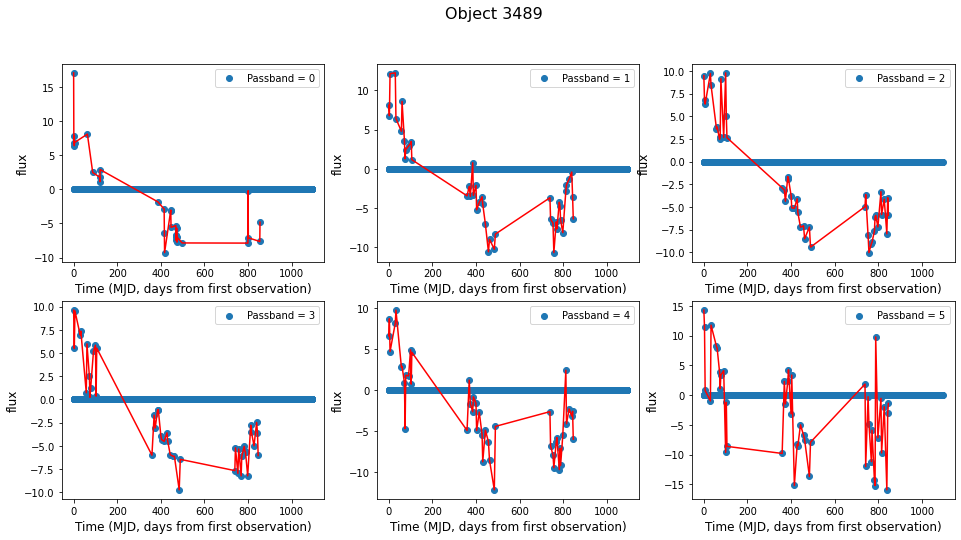

In [0]:
####plot the sparced light curve against the orignial.   
#####this is just a sanity check to make sure it worked 
obj_ind = 20

fig, ax = plt.subplots(2,3,figsize=(16,8)) 
fig.suptitle('Object ' + str(int(label_tracer[obj_ind]))\
                            , fontsize=16) 
for i in range(0,2): 
    for j in range(0,3):  
       print(i, j)
       ax[i,j].scatter(time_vector, flux_mat[obj_ind][((3* i)+ j) * time_vector.size:\
                                          ((3* i)+ j + 1) * time_vector.size],\
                                          label ='Passband = ' + str((3* i)+ j))
       
       ax[i,j].plot(lcvs[(lcvs['object_id']==label_tracer[obj_ind]) & \
                         (lcvs['passband']== (3* i)+ j)]['mjd_new_rnd'],\
                            lcvs[(lcvs['object_id']==label_tracer[obj_ind])\
                            & (lcvs['passband']== (3* i)+ j)]['flux'], c = 'r')
       
       ax[i,j].set_xlabel('Time (MJD, days from first observation)', fontsize=12) 
       ax[i,j].set_ylabel('flux', fontsize=12 ) 
       ax[i,j].legend()





Figure: Above is the plotting of the orginal platiccs light curve (red) plotted on top of the light curves in their refined temporal grid. Each sublot is for a different filter. The choice to shift some of the values to avoid repeats would cause small offsests for some observations, but it should cost much of the information of the light curve considering the size of time scales of observations and events. 

###**Building the Neural Network/ Auto Encoder**

In [0]:
from sklearn.model_selection import train_test_split
X_tr,  X_test, y_tr, y_test = train_test_split( light_curve_mat, light_curve_mat , 
                                             test_size = .30, random_state=4)



In [0]:
X_tr.shape, X_test.shape, y_tr.shape, y_test.shape

((5493, 13141), (2355, 13141), (5493, 13141), (2355, 13141))

In [0]:
X_tr[:,1:]


array([[  0.740755,   0.      ,  -1.182402, ...,   0.      ,   0.      ,
          0.      ],
       [ -3.832366,   0.      ,   4.573449, ...,   0.      ,   0.      ,
          0.      ],
       [213.701019,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [-20.441778,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [ -1.584707,   0.      ,  -1.611393, ...,   0.      ,   0.      ,
          0.      ],
       [  1.864051,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ]])

### My Auto encoder 

My choice in using sychronized sparsed arrays benefits me in making passing in the data simpler, but it most liikely come at a heavy price for having the vector heavily populated with 0's. Thus i created an auto encoder (fully connected)  with seven lays, 3 prior to the bottle neck for compression and a symmetric set of 3 following it to decompress. It goes from an input of 13140, to a layer with 2190, to 730, to 73 and then to 10 node and back.   

*   The size of the time vector has a factor of a prime number ( 73 is the central and prime factor 13140 ) so it was not possible to have an cassace to the bottle neck, which each layer having a factor of node of the other. Essentially, a bottle neck of low dimensionality that would still be useful to add to feature space, but there are no factors to chose from 73. That jump from 73 to 10 may cost me information, but probably not as consequentail as all the 0's in the vector.

*   I put though in to the decision of the first hidden layer. Given that flux vector is evenly segments in to the different filters, I wanted a hidden lay that would have some multiple of that many wieght. The outcome that I hoped for was the the AE would generate weights associated with each band individually (ideally preserve some information from different fitlers), assuming it would start to learn that data seem relagated to specific segments.  

*   My chose to mainly use the rectified linear unit activation fucntion was mostly becasue of the sparsity of the data, so I was unsure what function would work. Also, its inexpensive computationally add easy to me trying out various configurations of the AE  and training it. 
*   My choice in loss fucntion mean squared error, pretty to punish the model for large mistakes, given the amount of sparsity it has to learn around. Over popualting a prediction with 0 where large modest flux readout would be, would trigger the AE to correct it rather than leave it be.


*   My choice in using the sigmoid in the final decompession/ output layer was becasue it know but it shape to be good with predicitng output (in this case reconstrucitng the input) 


*   I chose adadelta as my optimizer because it is known to be appropriate for sparse data, as well as adagrad, but it compensate for the rapid drop in learning by relying on a limited window of previous desents about the gradient. This family of optimizer seem to slow it rate for recurrent features (which will handle most of the zeros in the vector), and increase learning on outstanding features, so hopefully at least notice significant fluxes and variations by color. Aiming higher with more optimal learning, it could start to see the structure in the light curves Granted with this many paramaeters, the gradaitent-dependent optimization may suffer.



In [0]:
model_lcurve = Sequential() 
#### the encoder 
model_lcurve.add(Dense(2190,  activation='relu',input_dim= flux_mat.shape[1]))
model_lcurve.add(Dense(730, activation='relu'))
model_lcurve.add(Dense(73, activation='relu'))
#### center layer  / bottleneck 

model_lcurve.add(Dense(10, activation='relu'))

####decode

model_lcurve.add(Dense(73, activation='relu'))
model_lcurve.add(Dense(730, activation='relu'))
model_lcurve.add(Dense(2190, activation='relu'))
model_lcurve.add(Dense(flux_mat.shape[1], activation='sigmoid')) #sigmoid

model_lcurve.compile(optimizer="adadelta", loss="mean_squared_error") 


In [0]:
print(model_lcurve.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2190)              28778790  
_________________________________________________________________
dense_2 (Dense)              (None, 730)               1599430   
_________________________________________________________________
dense_3 (Dense)              (None, 73)                53363     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                740       
_________________________________________________________________
dense_5 (Dense)              (None, 73)                803       
_________________________________________________________________
dense_6 (Dense)              (None, 730)               54020     
_________________________________________________________________
dense_7 (Dense)              (None, 2190)             

Train on 5493 samples, validate on 2355 samples
Epoch 1/1000
5493/5493 [==============================] - 2s 333us/step - loss: 101452.3630 - val_loss: 387099.8927
Epoch 2/1000
5493/5493 [==============================] - 2s 280us/step - loss: 101452.1447 - val_loss: 387099.8587
Epoch 3/1000
5493/5493 [==============================] - 2s 277us/step - loss: 101452.0762 - val_loss: 387099.7879
Epoch 4/1000
5493/5493 [==============================] - 2s 280us/step - loss: 101452.0911 - val_loss: 387099.9037
Epoch 5/1000
5493/5493 [==============================] - 2s 276us/step - loss: 101452.0806 - val_loss: 387099.8375
Epoch 6/1000
5493/5493 [==============================] - 2s 278us/step - loss: 101452.0882 - val_loss: 387099.8685
Epoch 7/1000
5493/5493 [==============================] - 2s 280us/step - loss: 101452.1316 - val_loss: 387099.8930
Epoch 8/1000
5493/5493 [==============================] - 2s 276us/step - loss: 101452.1434 - val_loss: 387099.8946
Epoch 9/1000
5493/5493 [

Text(0.5, 0, 'iteration')

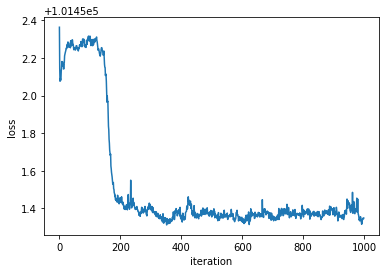

In [0]:
history_model_lcurve = model_lcurve.fit(X_tr[:,1:], X_tr[:,1:], 
                                       validation_data=(X_test[:,1:], X_test[:,1:]), 
                                       epochs=1000, batch_size=500, verbose=1)

#model_lcurve.save("hw9_model_sig_ep1000_bch500_2.h5")


pl.plot(np.array(history_model_lcurve.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')



In [0]:
#model_lcurve.load_weights("hw9_model_sig_ep1000_bch500_2.h5")
#####loading in the model above 


Text(0.5, 0, 'iteration')

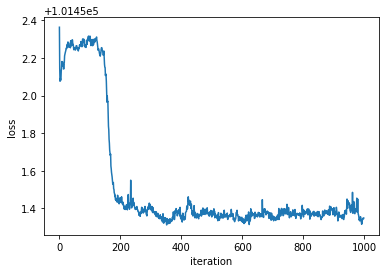

In [0]:
####just in case you run the history cell again. This
#####is the loss function for the loaded model.


Figure: The loss function for the AE that we built. It seems that htis model rapid learns most of the light curves, and is pretty much familar with it by the 400th iteration. This could be concening, such that it might be overfitting to the training set. As I see based on the adadelta optimizer, it learned the recuriring feautures (all the 0's), them moved on to quickly to learning the rare unique features. This the outcome to the saved model that is loaded in. This plot in  the origianl unrun version is the basis of the model i address in my discussions.

In [0]:
output_lcurve = model_lcurve.predict(X_test[:,1:])

In [0]:
output_lcurve.shape

(2355, 13140)

0 0
0 1
0 2
1 0
1 1
1 2


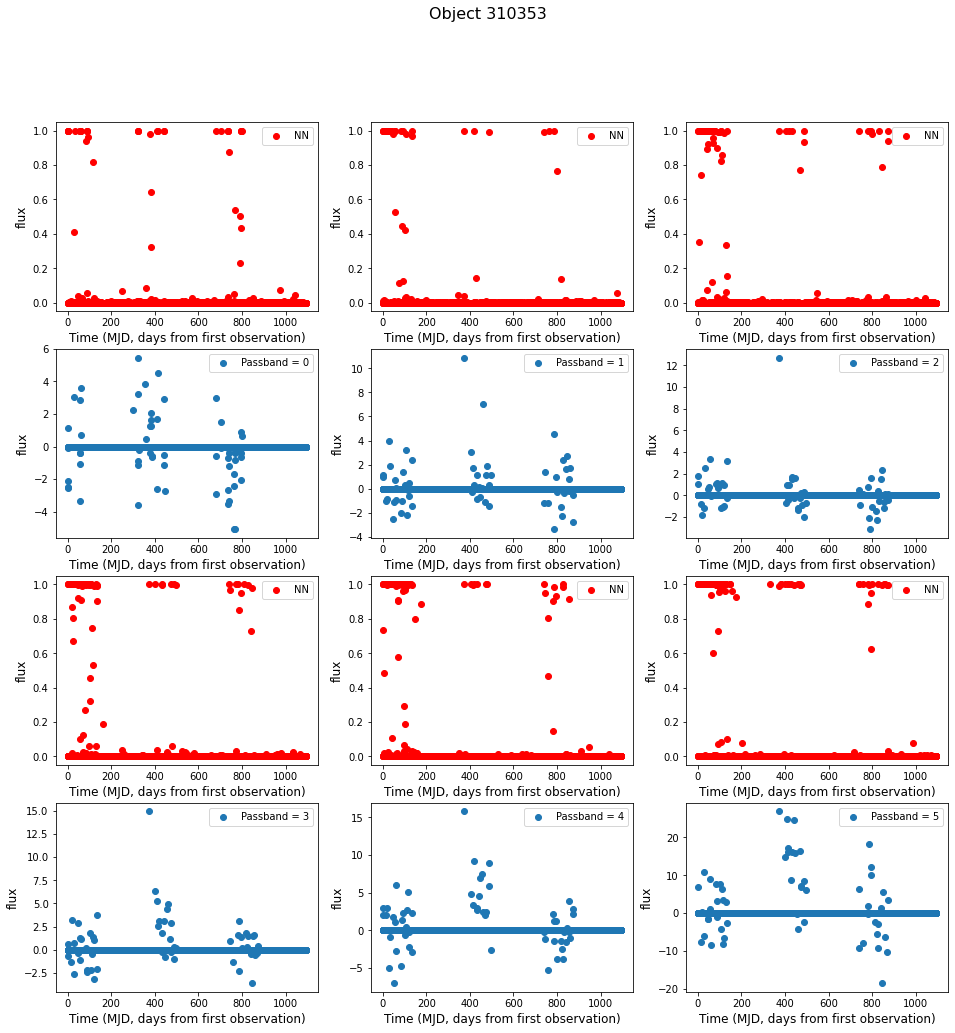

In [0]:
#### plottting the predictions of the autoencoder 
obj_ind = 60

fig, ax = plt.subplots(4,3,figsize=(16,16)) 
fig.suptitle('Object ' + str(int(X_test[obj_ind][0]))\
                            , fontsize=16) 
for i in range(0,2): 
    for j in range(0,3):  
       print(i, j)
       ax[(i*2),j].scatter(time_vector, output_lcurve[obj_ind][((3* i)+ j) * time_vector.size:\
                                          ((3* i)+ j + 1) * time_vector.size],\
                                          c ='r', label ='NN')
       
       ax[(i*2) +1,j].scatter(time_vector, X_test[obj_ind][((3* i)+ j) * time_vector.size +1:\
                                          ((3* i)+ j + 1) * time_vector.size+1],\
                                          label ='Passband = ' + str((3* i)+ j))
       
       ax[(i*2),j].set_xlabel('Time (MJD, days from first observation)', fontsize=12) 
       ax[(i*2),j].set_ylabel('flux', fontsize=12 ) 
       ax[(i*2),j].legend()

       ax[(i*2) +1,j].set_xlabel('Time (MJD, days from first observation)', fontsize=12) 
       ax[(i*2) +1,j].set_ylabel('flux', fontsize=12 ) 
       ax[(i*2) +1,j].legend()

Figure: Above are 12 subplot frames comparing the light curves produced by the auto encoder( red, rows 1 and 3) with the  orginal light curves from the training set (blue, rows 2 and 4). Each respective column pair is the light curve in a given filter. From the figure it seems about how we used sparsed lights, possibly becasue we populated it with too many 0 values. The NN might not be able to make an assocaitions with magnitudes of significant fluxes, but seems to have did preserved some temporal information about the curves, given the synchrony of the time stamps of the point. I also see my reliance on relu may have cost information as far as an obejct have a negative flux, which in an actual survey would be BAD, becasue it elimiates the dim observations. But the loss function seem to have forced it not to lose track of significant events. 

0 0
0 1
0 2
1 0
1 1
1 2


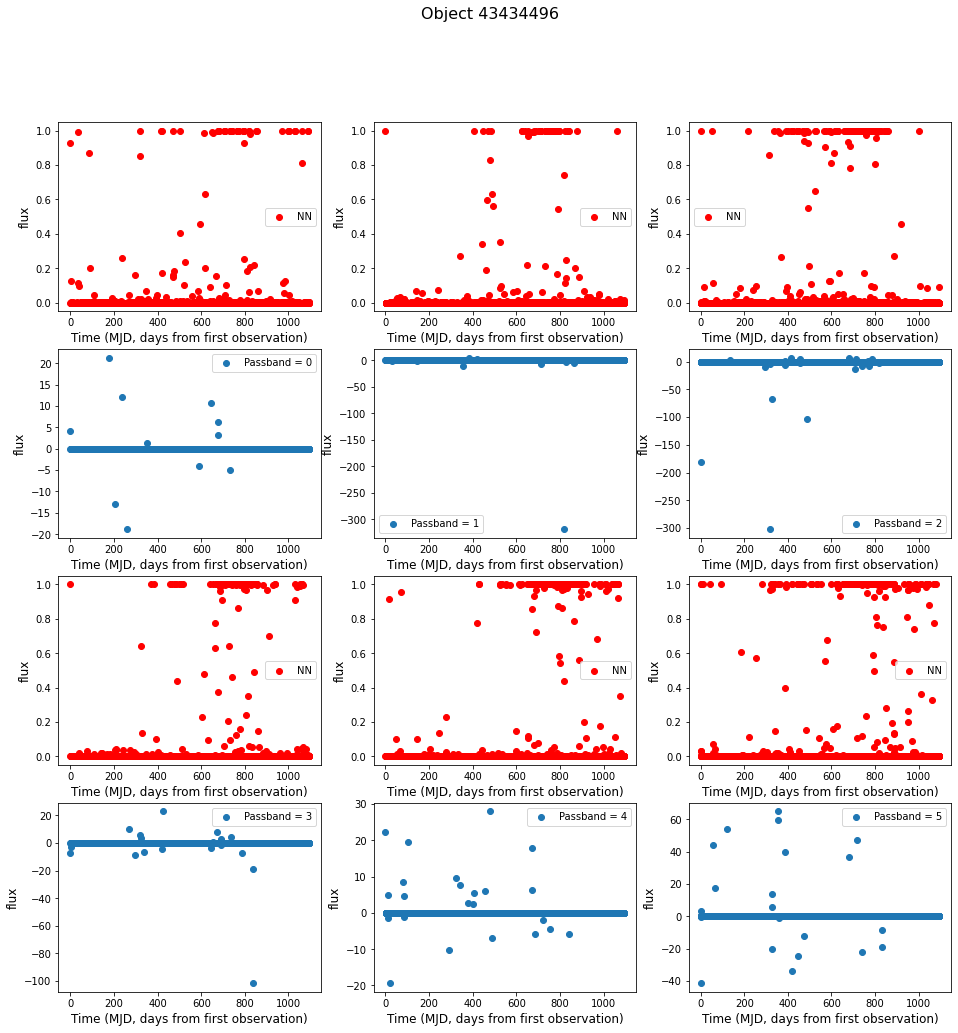

In [0]:
#### plottting the predictions of the autoencoder 
obj_ind = 1233

fig, ax = plt.subplots(4,3,figsize=(16,16)) 
fig.suptitle('Object ' + str(int(X_test[obj_ind][0]))\
                            , fontsize=16) 
for i in range(0,2): 
    for j in range(0,3):  
       print(i, j)
       ax[(i*2),j].scatter(time_vector, output_lcurve[obj_ind][((3* i)+ j) * time_vector.size:\
                                          ((3* i)+ j + 1) * time_vector.size],\
                                          c ='r', label ='NN')
       
       ax[(i*2) +1,j].scatter(time_vector, X_test[obj_ind][((3* i)+ j) * time_vector.size +1:\
                                          ((3* i)+ j + 1) * time_vector.size+1],\
                                          label ='Passband = ' + str((3* i)+ j))
       
       ax[(i*2),j].set_xlabel('Time (MJD, days from first observation)', fontsize=12) 
       ax[(i*2),j].set_ylabel('flux', fontsize=12 ) 
       ax[(i*2),j].legend()

       ax[(i*2) +1,j].set_xlabel('Time (MJD, days from first observation)', fontsize=12) 
       ax[(i*2) +1,j].set_ylabel('flux', fontsize=12 ) 
       ax[(i*2) +1,j].legend()

Figure: Above is a similar plot for a different object. As we see the NN does preserve the temoral structure of this object and is seeing small change in flux as significant. From this, combined with the rapid drop of the loss function it seems that the AE learned the traning set very well, so it might be over fitted, to the extent that it can't dissociate positive and negative fluxes, and what measures are significant. 

In [0]:
####checking the training set 
output_lcurve_tr = model_lcurve.predict(X_tr[:,1:])

0 0
0 1
0 2
1 0
1 1
1 2


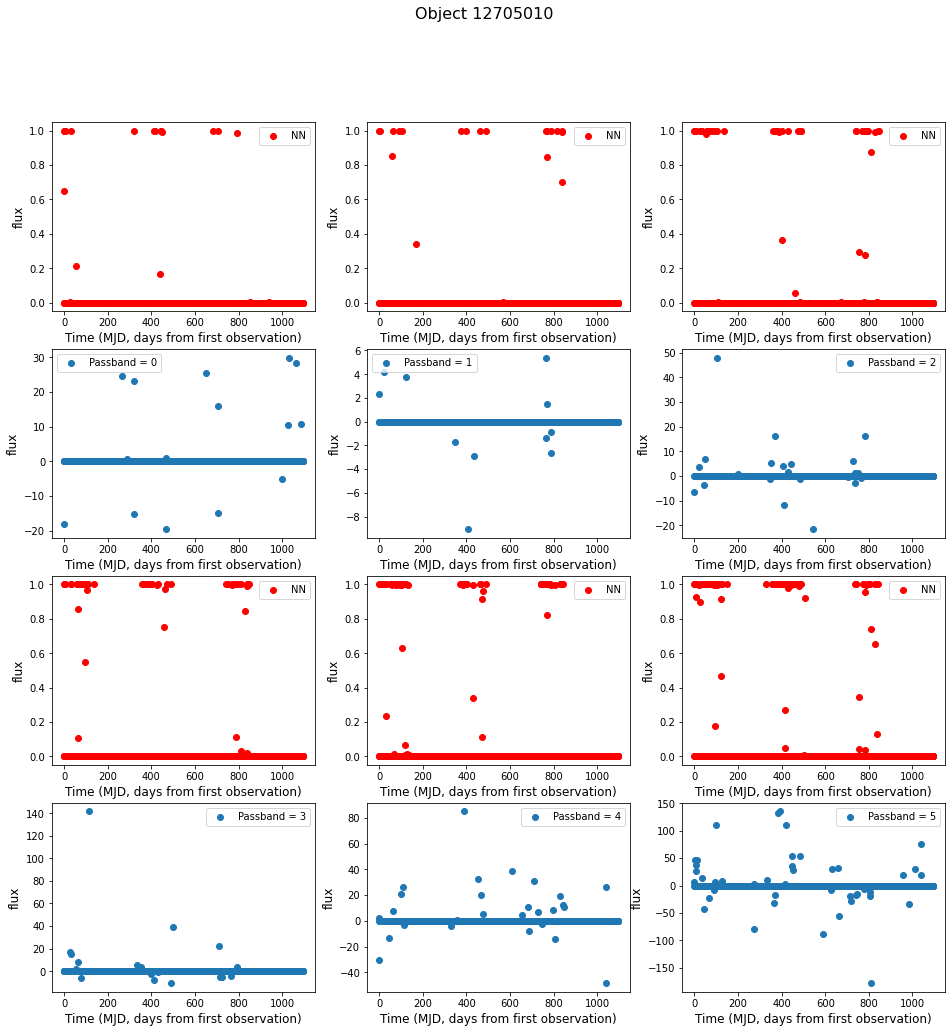

In [0]:
#### plottting the predictions of the autoencoder 
obj_ind = 400

fig, ax = plt.subplots(4,3,figsize=(16,16)) 
fig.suptitle('Object ' + str(int(X_tr[obj_ind][0]))\
                            , fontsize=16) 
for i in range(0,2): 
    for j in range(0,3):  
       print(i, j)
       ax[(i*2),j].scatter(time_vector, output_lcurve_tr[obj_ind][((3* i)+ j) * time_vector.size:\
                                          ((3* i)+ j + 1) * time_vector.size],\
                                          c ='r', label ='NN')
       
       ax[(i*2) +1,j].scatter(time_vector, X_tr[obj_ind][((3* i)+ j) * time_vector.size +1:\
                                          ((3* i)+ j + 1) * time_vector.size+1],\
                                          label ='Passband = ' + str((3* i)+ j))
       
       ax[(i*2),j].set_xlabel('Time (MJD, days from first observation)', fontsize=12) 
       ax[(i*2),j].set_ylabel('flux', fontsize=12 ) 
       ax[(i*2),j].legend()

       ax[(i*2) +1,j].set_xlabel('Time (MJD, days from first observation)', fontsize=12) 
       ax[(i*2) +1,j].set_ylabel('flux', fontsize=12 ) 
       ax[(i*2) +1,j].legend()

Figure: Same plot but inspecting an object from the training set. It seems to well infromed about the time time of siginificant flux flux measurements for this object. It also seems that is relying on the adjancent filter to make its predictions. From the training set also, the scaling may be a consequene of over populating the time series with 0's.

In [0]:

# extracting  the bottle neck outputs
botneck_data = model_lcurve.layers[3].output

inp = model_lcurve.input 

functors = K.function([inp], [botneck_data]) 
layer_outs = functors(X_test[:,1:])


In [0]:
####inspecting the structure of the array
np.shape(layer_outs)

(1, 2355, 10)

In [0]:
###these will be the for out feature space 
layer_outs_feat = functors(light_curve_mat[:,1:])

In [0]:
np.shape(layer_outs_feat)

(1, 7848, 10)

In [0]:
np.shape(layer_outs_feat[0][:,1])

(7848,)

### Bringing in the metadata and feature space from HW6. The coding procedure comes from hw6.  

In [0]:
metadata = pd.read_csv("hw_5_dat/plasticc_train_metadata.csv")

In [0]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
allfeatures = pd.read_csv("hw5_allfeatures.csv")

In [0]:
allfeatures.head()

,Unnamed: 0,"(0, 'mean')","(0, 'std')","(0, 'm2')","(0, 'm3')","(0, 'maxs')","(0, 'mins')","(0, 'median')","(0, 'slopes')","(0, 'intercepts')","(0, 'll1')","(0, 'll3')","(1, 'mean')","(1, 'std')","(1, 'm2')","(1, 'm3')","(1, 'maxs')","(1, 'mins')","(1, 'median')","(1, 'slopes')","(1, 'intercepts')","(1, 'll1')","(1, 'll2')","(1, 'll3')","(2, 'mean')","(2, 'std')","(2, 'm2')","(2, 'm3')","(2, 'maxs')","(2, 'mins')","(2, 'median')","(2, 'slopes')","(2, 'intercepts')","(2, 'll1')","(2, 'll2')","(2, 'll3')","(3, 'mean')","(3, 'std')","(3, 'm2')","(3, 'm3')","(3, 'maxs')","(3, 'mins')","(3, 'median')","(3, 'slopes')","(3, 'intercepts')","(3, 'll1')","(3, 'll2')","(3, 'll3')","(4, 'mean')","(4, 'std')","(4, 'm2')","(4, 'm3')","(4, 'maxs')","(4, 'mins')","(4, 'median')","(4, 'slopes')","(4, 'intercepts')","(4, 'll1')","(4, 'll2')","(4, 'll3')","(5, 'mean')","(5, 'std')","(5, 'm2')","(5, 'm3')","(5, 'maxs')","(5, 'mins')","(5, 'median')","(5, 'slopes')","(5, 'intercepts')","(5, 'll1')","(5, 'll2')","(5, 'll3')",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,0,-3.254554,83.944735,6934.865833,6934.865833,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-84.013092,-1.0,-385.699911,601.787302,355904.026224,355904.026224,660.626343,-1100.440063,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,203564.138816,203564.138816,611.984558,-681.858887,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,-121.103501,335.425053,110570.138947,110570.138947,445.737061,-530.644592,-0.122434,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,83681.162283,83681.162283,381.953735,-422.184509,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,85370.493377,85370.493377,378.188141,-422.815094,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,1,-2.720398,7.113509,49.879128,49.879128,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-45.801483,-1.0,-1.019804,5.712334,32.048070,32.048070,9.129021,-11.715749,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,32.706748,32.706748,10.529041,-10.067919,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,-0.986966,6.450413,40.864832,40.864832,11.330316,-12.394593,0.141552,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,40.316483,40.316483,9.827934,-12.286801,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,49.427194,49.427194,14.770886,-14.211164,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,2,-0.048080,1.828872,3.298318,3.298318,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.249926,-1.0,0.141057,1.807229,3.203266,3.203266,5.693109,-3.393080,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,30.313471,30.313471,20.994711,-2.848838,-0.343392,0.026905,-0.686084,-63.777334,-65.193298,1.0,3.236164,8.191987,65.818099,65.818099,33.572102,-5.435799,-0.314425,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,112.462234,112.462234,41.159981,-5.836310,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,174.276892,174.276892,47.310059,-19.159811,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,3,1.797523,4.374445,18.869993,18.869993,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-88.423048,-1.0,5.717394,25.964659,662.124902,662.124902,192.244293,-3.618410,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1003.075853,1003.075853,220.795212,-2.159753,-0.290606,-0.003878,0.106641,-72.846380,-78.938052,-1.0,14.412924,34.967698,1200.905234,1200.905234,203.250702,-4.944036,-0.373246,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.069053,1074.034376,1074.034376,183.633118,-15.494463,-0.358773,-0.004774,0.131296,-67.067827,-78.924149,-1.0,10.746138,26.060130,666.782529,666.782529,141.513290,-10.249387,-0.306851,-0.002816,0.076043,-64.783463,-77.536999,-1.0,-45.5867,1,0.281,1.152,

In [0]:
######just making sure they have the same row shape
allfeatures.shape

(7848, 77)

In [0]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1] - 1))

My feature space is 76 features (columns)


In [0]:
###removing unnamed column 
allfeatures = allfeatures.drop(columns = ['Unnamed: 0'])

In [0]:
# -- personally I choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [0]:
####checking for nans and inifinities, acquire from Dr. Bianco hw 5 solution
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))

there are 0 NaN and 0 infinity entries


Bringing the AE bottleneck into feature space dataframe. 
Becuase we chose to string all filters in to one vector, they would all share
the same feature values, given how the NN tried to learn about them. I also double checks past assignemts to make sure all three files( light_curve_arr, metadata, and feature df) we all of the same shape. 

In [0]:
####adding the new columns 
allfeatures['AE_0'] =  layer_outs_feat[0][:,0]

allfeatures['AE_1'] =  layer_outs_feat[0][:,1]

allfeatures['AE_2'] =  layer_outs_feat[0][:,2]

allfeatures['AE_3'] =  layer_outs_feat[0][:,3]

allfeatures['AE_4'] =  layer_outs_feat[0][:,4]

allfeatures['AE_5'] =  layer_outs_feat[0][:,5]

allfeatures['AE_6'] =  layer_outs_feat[0][:,6]

allfeatures['AE_7'] =  layer_outs_feat[0][:,7]

allfeatures['AE_8'] =  layer_outs_feat[0][:,8]

allfeatures['AE_9'] =  layer_outs_feat[0][:,9]

In [0]:
allfeatures.tail()

,"(0, 'mean')","(0, 'std')","(0, 'm2')","(0, 'm3')","(0, 'maxs')","(0, 'mins')","(0, 'median')","(0, 'slopes')","(0, 'intercepts')","(0, 'll1')","(0, 'll3')","(1, 'mean')","(1, 'std')","(1, 'm2')","(1, 'm3')","(1, 'maxs')","(1, 'mins')","(1, 'median')","(1, 'slopes')","(1, 'intercepts')","(1, 'll1')","(1, 'll2')","(1, 'll3')","(2, 'mean')","(2, 'std')","(2, 'm2')","(2, 'm3')","(2, 'maxs')","(2, 'mins')","(2, 'median')","(2, 'slopes')","(2, 'intercepts')","(2, 'll1')","(2, 'll2')","(2, 'll3')","(3, 'mean')","(3, 'std')","(3, 'm2')","(3, 'm3')","(3, 'maxs')",...,"(3, 'll3')","(4, 'mean')","(4, 'std')","(4, 'm2')","(4, 'm3')","(4, 'maxs')","(4, 'mins')","(4, 'median')","(4, 'slopes')","(4, 'intercepts')","(4, 'll1')","(4, 'll2')","(4, 'll3')","(5, 'mean')","(5, 'std')","(5, 'm2')","(5, 'm3')","(5, 'maxs')","(5, 'mins')","(5, 'median')","(5, 'slopes')","(5, 'intercepts')","(5, 'll1')","(5, 'll2')","(5, 'll3')",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target,AE_0,AE_1,AE_2,AE_3,AE_4,AE_5,AE_6,AE_7,AE_8,AE_9
7843,1.286655,15.998517,2.408965e+02,2.408965e+02,51.247578,-23.468113,-0.045003,0.010847,-0.086780,-23.432623,1.0,11.604012,42.103636,1.646094e+03,1.646094e+03,157.191650,-3.726851,-0.282994,0.056925,-0.370012,-18.558453,-18.584142,1.0,1.487066,9.781002,9.168183e+01,9.168183e+01,38.534805,-7.384562,-0.281585,0.009331,-0.107307,-33.397434,-33.524543,-1.0,4.696556,9.132244,8.006196e+01,8.006196e+01,23.924580,...,1.0,-1.326906,16.735430,2.713223e+02,2.713223e+02,46.577839,-35.209919,-0.029408,-0.015218,0.235874,-43.831962,-44.493536,-1.0,20.073462,97.602719,9.254111e+03,9.254111e+03,517.602478,-105.375282,-0.091638,-0.021912,0.372506,-47.963730,-48.247356,1.0,-14.9403,0,0.000,0.000,65,292.535034,634.370361,38.661854,79.913818,204.261642,419.742554,0.0,0.0,223.150513,0.000000
7844,24.635243,79.713932,5.824785e+03,5.824785e+03,271.930481,-22.168346,-0.264846,-0.062990,0.346445,-15.325622,-1.0,6.965825,16.268582,2.406062e+02,2.406062e+02,54.464066,-2.173342,-0.351126,-0.014109,0.070543,-13.870156,-15.035801,-1.0,-0.779640,4.606559,2.004148e+01,2.004148e+01,8.301914,-9.390373,0.066620,0.049441,-0.420251,-21.233756,-24.236322,-1.0,27.147503,88.177979,7.219973e+03,7.219973e+03,329.695709,...,-1.0,40.758273,108.319727,1.126384e+04,1.126384e+04,363.402466,-43.322540,-0.331122,0.009737,-0.116845,-32.256807,-34.952720,-1.0,3.528390,38.849765,1.464913e+03,1.464913e+03,135.327408,-69.036392,-0.108422,-0.003058,0.050458,-47.569288,-47.724129,-1.0,-62.6967,0,2.561,1.115,90,0.000000,296.076996,0.000000,0.000000,0.000000,114.054848,0.0,0.0,705.808533,0.000000
7845,-0.282914,46.605187,2.004963e+03,2.004963e+03,52.152622,-135.602631,0.164351,-0.057516,0.345093,-17.372063,1.0,-20.094296,23.572412,5.229728e+02,5.229728e+02,9.115225,-90.300354,0.081505,0.109119,-0.872951,-20.286207,-20.647956,-1.0,-28.388796,29.855715,8.542236e+02,8.542236e+02,27.459307,-80.965820,-0.023363,-0.004481,0.051530,-32.714050,-33.536138,-1.0,-13.723449,31.491707,9.333907e+02,9.333907e+02,60.889641,...,1.0,-15.201844,22.364118,4.845240e+02,4.845240e+02,37.266300,-49.501961,-0.107204,0.010708,-0.165973,-44.623068,-44.623897,-1.0,-9.838345,48.309960,2.258567e+03,2.258567e+03,169.916672,-87.510719,-0.026542,0.003563,-0.053441,-43.413986,-43.476462,-1.0,-55.6821,0,0.000,0.000,16,167.606995,434.678162,81.596451,150.116409,220.152573,621.445984,0.0,0.0,0.000000,34.688499
7846,3.374208,14.420201,1.930892e+02,1.930892e+02,37.959984,-11.813696,-0.350661,0.019048,-0.123810,-19.054708,1.0,28.342250,97.513710,8.644476e+03,8.644476e+03,322.255371,-5.291557,-0.302563,0.121633,-0.608166,-14.032730,-14.391069,1.0,0.618994,6.550608,4.119405e+01,4.119405e+01,26.298336,-7.638723,-0.006650,0.022282,-0.267382,-33.485612,-34.352386,-1.0,-0.357920,7.667434,5.643796e+01,5.643796e+01,17.559683,...,-1.0,-1.135067,10.112169,9.872990e+01,9.872990e+01,17.072502,-23.747828,0.083647,-0.011086,0.155199,-38.567032,-40.557675,1.0,7.671389,44.169662,1.902185e+03,1.902185e+03,211.992584,-51.927830,-0.10

In [0]:
####adding object id 

allfeatures['object_id'] = metadata['object_id']

In [0]:
allfeatures.tail()

,"(0, 'mean')","(0, 'std')","(0, 'm2')","(0, 'm3')","(0, 'maxs')","(0, 'mins')","(0, 'median')","(0, 'slopes')","(0, 'intercepts')","(0, 'll1')","(0, 'll3')","(1, 'mean')","(1, 'std')","(1, 'm2')","(1, 'm3')","(1, 'maxs')","(1, 'mins')","(1, 'median')","(1, 'slopes')","(1, 'intercepts')","(1, 'll1')","(1, 'll2')","(1, 'll3')","(2, 'mean')","(2, 'std')","(2, 'm2')","(2, 'm3')","(2, 'maxs')","(2, 'mins')","(2, 'median')","(2, 'slopes')","(2, 'intercepts')","(2, 'll1')","(2, 'll2')","(2, 'll3')","(3, 'mean')","(3, 'std')","(3, 'm2')","(3, 'm3')","(3, 'maxs')",...,"(4, 'mean')","(4, 'std')","(4, 'm2')","(4, 'm3')","(4, 'maxs')","(4, 'mins')","(4, 'median')","(4, 'slopes')","(4, 'intercepts')","(4, 'll1')","(4, 'll2')","(4, 'll3')","(5, 'mean')","(5, 'std')","(5, 'm2')","(5, 'm3')","(5, 'maxs')","(5, 'mins')","(5, 'median')","(5, 'slopes')","(5, 'intercepts')","(5, 'll1')","(5, 'll2')","(5, 'll3')",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target,AE_0,AE_1,AE_2,AE_3,AE_4,AE_5,AE_6,AE_7,AE_8,AE_9,object_id
7843,1.286655,15.998517,2.408965e+02,2.408965e+02,51.247578,-23.468113,-0.045003,0.010847,-0.086780,-23.432623,1.0,11.604012,42.103636,1.646094e+03,1.646094e+03,157.191650,-3.726851,-0.282994,0.056925,-0.370012,-18.558453,-18.584142,1.0,1.487066,9.781002,9.168183e+01,9.168183e+01,38.534805,-7.384562,-0.281585,0.009331,-0.107307,-33.397434,-33.524543,-1.0,4.696556,9.132244,8.006196e+01,8.006196e+01,23.924580,...,-1.326906,16.735430,2.713223e+02,2.713223e+02,46.577839,-35.209919,-0.029408,-0.015218,0.235874,-43.831962,-44.493536,-1.0,20.073462,97.602719,9.254111e+03,9.254111e+03,517.602478,-105.375282,-0.091638,-0.021912,0.372506,-47.963730,-48.247356,1.0,-14.9403,0,0.000,0.000,65,292.535034,634.370361,38.661854,79.913818,204.261642,419.742554,0.0,0.0,223.150513,0.000000,130739978
7844,24.635243,79.713932,5.824785e+03,5.824785e+03,271.930481,-22.168346,-0.264846,-0.062990,0.346445,-15.325622,-1.0,6.965825,16.268582,2.406062e+02,2.406062e+02,54.464066,-2.173342,-0.351126,-0.014109,0.070543,-13.870156,-15.035801,-1.0,-0.779640,4.606559,2.004148e+01,2.004148e+01,8.301914,-9.390373,0.066620,0.049441,-0.420251,-21.233756,-24.236322,-1.0,27.147503,88.177979,7.219973e+03,7.219973e+03,329.695709,...,40.758273,108.319727,1.126384e+04,1.126384e+04,363.402466,-43.322540,-0.331122,0.009737,-0.116845,-32.256807,-34.952720,-1.0,3.528390,38.849765,1.464913e+03,1.464913e+03,135.327408,-69.036392,-0.108422,-0.003058,0.050458,-47.569288,-47.724129,-1.0,-62.6967,0,2.561,1.115,90,0.000000,296.076996,0.000000,0.000000,0.000000,114.054848,0.0,0.0,705.808533,0.000000,130755807
7845,-0.282914,46.605187,2.004963e+03,2.004963e+03,52.152622,-135.602631,0.164351,-0.057516,0.345093,-17.372063,1.0,-20.094296,23.572412,5.229728e+02,5.229728e+02,9.115225,-90.300354,0.081505,0.109119,-0.872951,-20.286207,-20.647956,-1.0,-28.388796,29.855715,8.542236e+02,8.542236e+02,27.459307,-80.965820,-0.023363,-0.004481,0.051530,-32.714050,-33.536138,-1.0,-13.723449,31.491707,9.333907e+02,9.333907e+02,60.889641,...,-15.201844,22.364118,4.845240e+02,4.845240e+02,37.266300,-49.501961,-0.107204,0.010708,-0.165973,-44.623068,-44.623897,-1.0,-9.838345,48.309960,2.258567e+03,2.258567e+03,169.916672,-87.510719,-0.026542,0.003563,-0.053441,-43.413986,-43.476462,-1.0,-55.6821,0,0.000,0.000,16,167.606995,434.678162,81.596451,150.116409,220.152573,621.445984,0.0,0.0,0.000000,34.688499,130762946
7846,3.374208,14.420201,1.930892e+02,1.930892e+02,37.959984,-11.813696,-0.350661,0.019048,-0.123810,-19.054708,1.0,28.342250,97.513710,8.644476e+03,8.644476e+03,322.255371,-5.291557,-0.302563,0.121633,-0.608166,-14.032730,-14.391069,1.0,0.618994,6.550608,4.119405e+01,4.119405e+01,26.298336,-7.638723,-0.006650,0.022282,-0.267382,-33.485612,-34.352386,-1.0,-0.357920,7.667434,5.643796e+01,5.643796e+01,17.559683,...,-1.135067,10.112169,9.872990e+01,9.872990e+01,17.072502,-23.747828,0.083647,-0.011086,0.155199,-38.567032,-40.557675,1.0,7.671389,44.169662,1.902185e+03,1.902185e+03,211.992584,-51.927

In [0]:
####checking for nans and inifinities, acquire from Dr. Bianco hw 5 solution
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))

there are 0 NaN and 0 infinity entries


In [0]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1] - 1 ))

My feature space is 86 features (columns)


In [0]:
X = allfeatures.iloc[:,:-1]
y = allfeatures.iloc[:,-1]

In [0]:
y

0             615
1             713
2             730
3             745
4            1124
          ...    
7843    130739978
7844    130755807
7845    130762946
7846    130772921
7847    130779836
Name: object_id, Length: 7848, dtype: int64

In [0]:
X

,"(0, 'mean')","(0, 'std')","(0, 'm2')","(0, 'm3')","(0, 'maxs')","(0, 'mins')","(0, 'median')","(0, 'slopes')","(0, 'intercepts')","(0, 'll1')","(0, 'll3')","(1, 'mean')","(1, 'std')","(1, 'm2')","(1, 'm3')","(1, 'maxs')","(1, 'mins')","(1, 'median')","(1, 'slopes')","(1, 'intercepts')","(1, 'll1')","(1, 'll2')","(1, 'll3')","(2, 'mean')","(2, 'std')","(2, 'm2')","(2, 'm3')","(2, 'maxs')","(2, 'mins')","(2, 'median')","(2, 'slopes')","(2, 'intercepts')","(2, 'll1')","(2, 'll2')","(2, 'll3')","(3, 'mean')","(3, 'std')","(3, 'm2')","(3, 'm3')","(3, 'maxs')",...,"(3, 'll3')","(4, 'mean')","(4, 'std')","(4, 'm2')","(4, 'm3')","(4, 'maxs')","(4, 'mins')","(4, 'median')","(4, 'slopes')","(4, 'intercepts')","(4, 'll1')","(4, 'll2')","(4, 'll3')","(5, 'mean')","(5, 'std')","(5, 'm2')","(5, 'm3')","(5, 'maxs')","(5, 'mins')","(5, 'median')","(5, 'slopes')","(5, 'intercepts')","(5, 'll1')","(5, 'll2')","(5, 'll3')",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target,AE_0,AE_1,AE_2,AE_3,AE_4,AE_5,AE_6,AE_7,AE_8,AE_9
0,-3.254554,83.944735,6.934866e+03,6.934866e+03,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-84.013092,-1.0,-385.699911,601.787302,3.559040e+05,3.559040e+05,660.626343,-1100.440063,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,2.035641e+05,2.035641e+05,611.984558,-681.858887,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,-121.103501,335.425053,1.105701e+05,1.105701e+05,445.737061,...,-1.0,-55.954592,291.803449,8.368116e+04,8.368116e+04,381.953735,-422.184509,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,8.537049e+04,8.537049e+04,378.188141,-422.815094,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92,764.557434,14981.924805,1212.294312,3192.239746,3500.606934,19288.992188,0.0,0.0,0.000000,1043.667725
1,-2.720398,7.113509,4.987913e+01,4.987913e+01,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-45.801483,-1.0,-1.019804,5.712334,3.204807e+01,3.204807e+01,9.129021,-11.715749,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,3.270675e+01,3.270675e+01,10.529041,-10.067919,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,-0.986966,6.450413,4.086483e+01,4.086483e+01,11.330316,...,-1.0,-0.900262,6.406989,4.031648e+01,4.031648e+01,9.827934,-12.286801,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,4.942719e+01,4.942719e+01,14.770886,-14.211164,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88,102.149078,24.490892,49.323067,34.985104,91.301559,70.291885,0.0,0.0,0.000000,7.895730
2,-0.048080,1.828872,3.298318e+00,3.298318e+00,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.249926,-1.0,0.141057,1.807229,3.203266e+00,3.203266e+00,5.693109,-3.393080,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,3.031347e+01,3.031347e+01,20.994711,-2.848838,-0.343392,0.026905,-0.686084,-63.777334,-65.193298,1.0,3.236164,8.191987,6.581810e+01,6.581810e+01,33.572102,...,1.0,4.308728,10.710344,1.124622e+02,1.124622e+02,41.159981,-5.836310,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,1.742769e+02,1.742769e+02,47.310059,-19.159811,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42,215.959030,332.029755,0.000000,0.000000,88.272095,53.267986,0.0,0.0,264.754486,0.000000
3,1.797523,4.374445,1.886999e+01,1.886999e+01,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-88.423048,-1.0,5.717394,25.964659,6.621249e+02,6.621249e+02,192.244293,-3.618410,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1.003076e+03,1.003076e+03,220.795212,-2.159753,-0.290606,-0.003878,0.106641,-72.846380,-78.938052,-1.0,14.412924,34.967698,1.200905e+03,1.200905e+03,203.250702,...,-1.0,13.134436,33.069053,1.074034e+03,1.074034e+03,183.633118,-15.494463,-0.358773,-0.004774,0.131296,-67.067827,-78.924149,-1.0,10.746138,26.060130,6.667825e+02,6.667825e+02,141.513290,-10.249387,-

In [0]:
####creating a normalized version of the df for extrac credit II
from sklearn import preprocessing
min_max_scale = preprocessing.MinMaxScaler()
X_norm = min_max_scale.fit_transform(X)
X_norm = pd.DataFrame(X_norm)

In [0]:
featuremeans = X_norm.mean()
featurestd = X_norm.std()
print("saved means and standard deviation arrays", featuremeans, featurestd)
print("number of observations {}, features {}, means {}, standard deviations {}".format\
      (X.shape, X.shape, featuremeans.shape[0], featurestd.shape[0]))

saved means and standard deviation arrays 0     0.013779
1     0.000218
2     0.000130
3     0.000130
4     0.000996
        ...   
81    0.001687
82    0.000000
83    0.000913
84    0.000738
85    0.002634
Length: 86, dtype: float64 0     0.011222
1     0.011379
2     0.011289
3     0.011289
4     0.011335
        ...   
81    0.017979
82    0.000000
83    0.017404
84    0.015843
85    0.024919
Length: 86, dtype: float64
number of observations (7848, 86), features (7848, 86), means 86, standard deviations 86


In [0]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0)) 

scaled training data feature mean and standard deviations:  [ 2.71614196e-18  2.71614196e-18  2.71614196e-18  2.71614196e-18
  5.43228391e-18 -1.81076130e-18  1.44860904e-17  1.44860904e-17
  1.81076130e-18  1.15888723e-16  6.51874070e-17  8.60111619e-18
 -2.94248712e-18 -3.62152261e-18 -3.62152261e-18 -9.95918717e-18
  1.35807098e-17 -8.69165426e-17 -2.35398970e-17 -9.05380652e-18
 -1.15888723e-16 -1.15888723e-16 -2.53506583e-17 -2.71614196e-18
 -5.77180166e-18 -1.81076130e-18 -1.81076130e-18  1.04118775e-17
  1.81076130e-18  7.24304522e-18  1.26753291e-17  1.81076130e-18
 -2.89721809e-16 -4.63554894e-16  8.32950200e-17 -4.52690326e-18
 -5.43228391e-18 -9.05380652e-19 -9.05380652e-19  2.26345163e-18
 -1.26753291e-17 -7.24304522e-17 -1.85603034e-17  1.35807098e-18
  1.73833085e-16 -2.31777447e-16  7.24304522e-18 -9.05380652e-19
  3.16883228e-18  1.81076130e-18  1.81076130e-18 -1.49387808e-17
  1.99183743e-17  4.34582713e-17  1.62968517e-17 -3.44044648e-17
  0.00000000e+00  4.63554894e-

In [0]:
from sklearn.manifold import TSNE



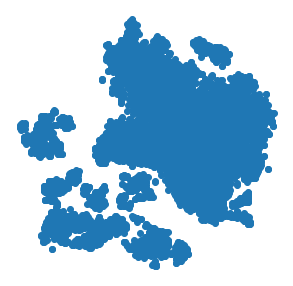

In [0]:
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X_scaled)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.axis('off')
pl.show()

Figure: Above is the 2D projection of the 86-dimensional feature space we created with extracted features from the time series.

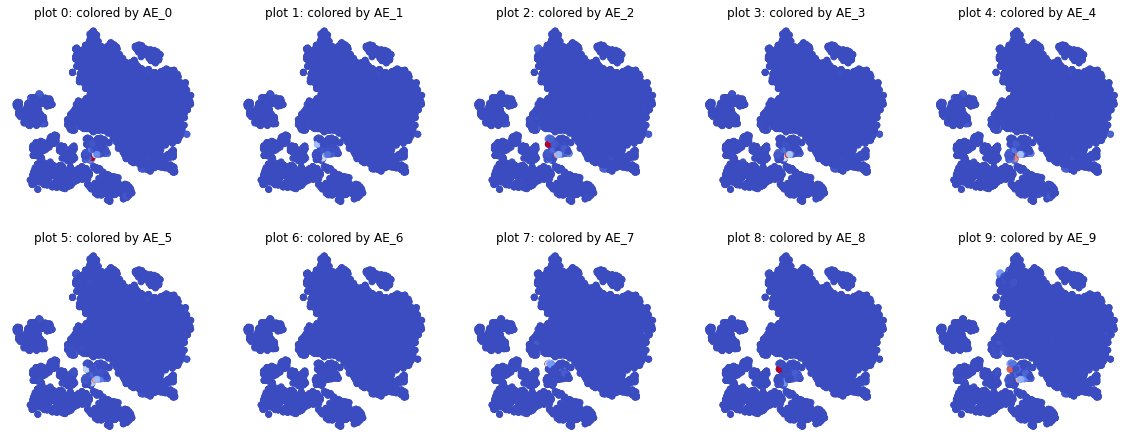

In [0]:
fig = pl.figure(figsize=(20,20))
# feature space projects specifically for the AE features
for i, col in enumerate(allfeatures.columns[76:86]):
    ax = fig.add_subplot(5,5,i+1)
    v = allfeatures[col].astype(float)
    ax.set_title("plot %d: colored by %s"%(i,col))
    ax.scatter(X_embedded[:,0], X_embedded[:,1],  
               color=[pl.cm.coolwarm(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    ax.axis('off')

Figure: the feature space is projected on a 2D plane via t-SNE method for the AutoEncoders features, and the points are colorcoded by the value of all metadata. Clearly, the features are the AE map the projection extremely poorly. 

### Beginning the random forest classifier. As with HW6 we break down the training and test set into DDF and normal. 

In [0]:
print("breakdown between surveys {} {}".format(
    (metadata.ddf_bool == 1).sum(), (metadata.ddf_bool == 0).sum()))

breakdown between surveys 2116 5732


In [0]:
##splitting by ddf and normal
#### X and y are index relative to the allfeature array
Xddf = X[allfeatures.ddf_bool==1]
Xnormal = X[allfeatures.ddf_bool==0]
yddf =  y[allfeatures.ddf_bool==1]
ynormal =  y[allfeatures.ddf_bool==0]

2116      1019335
2117      1091307
2118      1107992
2119      1135496
2120      1135692
          ...    
7843    130739978
7844    130755807
7845    130762946
7846    130772921
7847    130779836
Name: object_id, Length: 5732, dtype: int64

In [0]:
#Splitting the training and test set
import sklearn
from sklearn.model_selection import train_test_split

X_trainddf, X_testddf, y_trainddf, y_testddf = train_test_split(
     Xddf, yddf, test_size=0.6, train_size=0.4, random_state=42)

X_trainnormal, X_testnormal, y_trainnormal, y_testnormal = train_test_split(
     Xnormal, ynormal, test_size=0.6, train_size=0.4, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestClassifier
clfddf = RandomForestClassifier(n_estimators=100,\
                       criterion='gini', max_depth=5).fit(X_trainddf, y_trainddf)
clfnormal = RandomForestClassifier(n_estimators=100,\
                        criterion='gini', max_depth=5).fit(X_trainnormal, y_trainnormal)

In [0]:
print("Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           clfddf.score(X_testddf, y_testddf),
           clfnormal.score(X_testnormal, y_testnormal)))

Random Forest Classification
score on DDF 0.00 and on normal survey 0.00


Over all, the classifier seesm to to be completely inaccurate. As far as I can tell there  are no interfering bugs or procedures missing.

In [0]:
######building a confusion matrix 

#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_testddf, clfddf.predict(X_testddf))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

For some reason, the plotting of the confusion matrixs is maxing out the Ram. And also the random forrest is completely in accurate based on the score outputted. There are no obvious bugs, and the arrays are filled, but the classifier fails under any condtions, I have given it so far.

### Additional thought and reflections.

To some extent the auto enconder seemed to grasp the seperability/segmentation of the light curve , in order to preseve some infation in each band. The preservation of the temporal structure is most likely attributed to the adadelta optimizer. It preserved temporal informational well, but it may be over fitted to the training set. One possiblity is to ajust the structure of the AE, and one fix would be trial-and-error, adusting the depths and widths of the AE and see out put. Essentially combination of hidden layers, progressing toward low dimensionality in the bottleneck, and studying how well information is preserved.  Improvements could in utilizing some other activiation function, espeically one that puts more emphasis on non-zero value observations.I may have given it the wrong size batch to go back and optimize the parameters, or used too few epochs. One thing that is worth attemting is trying to spit up the data and interpolate, to have a structured light curve. With all those zeros in the vector, I would imagine it would be difficult to dissocaite structure from the sparsed data. However, I wanted only to study bright events, this would the type of AE to build from. 